# Model Analisis Sentimen Review Aplikasi - **DANA Dompet Digital Indonesia**

## Import Library

In [ ]:
# Standard library imports
import re
import string
import datetime as dt
import pickle

# Data manipulation and numerical computation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Natural Language Processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt_tab')

# Indonesian language processing
!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Machine learning evaluation
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Configuration
pd.options.mode.chained_assignment = None  # Disable pandas chained assignment warning
seed = 0
np.random.seed(seed)  # Set random seed for reproducibility

# Download NLTK resources
nltk.download('punkt')  # Tokenizer models
nltk.download('stopwords')  # Stopwords corpus

# Import required preprocessing utilities
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Conv1D,
    GlobalMaxPooling1D, Bidirectional, MaxPooling1D, Flatten, GRU, SimpleRNN,
    Input
)
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 11.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load Dataset

### Load & Display Dataset

In [ ]:
# Load dataset & display
url = "https://drive.google.com/uc?id=1LyPyD4rgfU_i5245xT9pbMCsUgs8GKi-&export=download"
data = pd.read_csv(url)

# Display dataset information
print(f"Total rows: {len(data):,}")
print(f"Total columns: {len(data.columns)}")

pd.set_option('display.max_colwidth', 50)
data.head(5)

Total rows: 31,500
Total columns: 11


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,89a65e8f-d581-4e00-9c4b-cb0184520d07,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Udah lama gak pake Spotify dan baru install la...,1,1574,9.0.28.630,2025-03-26 04:37:55,NaN,NaN,9.0.28.630
1,07a42ceb-abb6-427f-b5d9-3af499f165a4,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,dari dulu selalu ngandelin spotify kalau buat ...,1,168,9.0.32.624,2025-04-05 18:47:27,NaN,NaN,9.0.32.624
2,06822c8e-d1d7-4b4e-a945-6e6b45c12712,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Fitur shuffle dan smart shuffle Spotify payah ...,1,170,9.0.30.642,2025-03-29 21:56:50,NaN,NaN,9.0.30.642
3,4beda0fc-85a0-4373-bebd-f57dd6719314,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Saya belum lama menggunakan Aplikasi spotify, ...",5,62,9.0.32.624,2025-04-07 13:08:53,NaN,NaN,9.0.32.624
4,71e6a965-b4c8-4391-82fb-45e5f9c56a9f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Hp ku kemarin ke riset kan, jadi akunku yg udh...",2,44,9.0.30.642,2025-03-31 07:33:21,NaN,NaN,9.0.30.642


### Preparation Data

In [ ]:
# drop duplicate value
clean_df = data.drop_duplicates()

In [ ]:
# Display dataset information after cleaning
print(f"Total rows Dataset: {len(clean_df):,}")
print(f"Total columns Dataset: {len(clean_df.columns)}")

Total rows Dataset: 31,500
Total columns Dataset: 11


## Preprocessing Text

### Function Cleaning, casefolding, tokenizing, filtering, stemming, dan toSentence

In [ ]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy","yg","dah","pa","dah","ny","sy" "eh", "sya", "ko"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

### Function untuk Menangani Slang

In [ ]:
slangwords = {
    "@": "di", "abis": "habis", "wtb": "beli", "masi": "masih",
    "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal",
    "skrg": "sekarang", "tp": "tapi", "tdk": "tidak", "trs": "terus",
    "knp": "kenapa", "gpp": "gak apa-apa", "blm": "belum", "udh": "sudah",
    "sdh": "sudah", "dr": "dari", "dri": "dari", "mo": "mau",
    "mkn": "mungkin", "krn": "karena", "lbh": "lebih", "sbnrnya": "sebenarnya",
    "mending": "lebih baik", "plis": "tolong", "pake": "pakai",
    "bgt": "banget", "gmn": "gimana", "gaj": "gaji", "brp": "berapa",
    "trs": "terus", "ato": "atau", "cm": "cuma", "cmn": "cuman",
    "sm": "sama", "stiap": "setiap", "susah": "sulit", "tdk": "tidak", "gak": "tidak",
    "parah": "buruk", "lemot": "lambat", "sblm": "sebelum", "dlm": "dalam",
    "ribet": "sulit", "bgt": "banget", "kecewa": "tidak puas",
    "bikin": "membuat", "ga": "tidak", "aja": "saja", "lg": "lagi",
    "ni": "ini", "jd": "jadi", "tu": "itu", "biar": "supaya",
    "dpt": "dapat", "tp": "tapi", "otomati": "otomatis", "mulu": "selalu",
    "saldonya": "saldo", "klo": "jika", "dah": "sudah", "udah": "sudah",
    "apk": "aplikasi", "gk": "tidak"
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

### Terapkan

In [ ]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [ ]:
clean_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,89a65e8f-d581-4e00-9c4b-cb0184520d07,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Udah lama gak pake Spotify dan baru install la...,1,1574,9.0.28.630,2025-03-26 04:37:55,NaN,NaN,9.0.28.630,Udah lama gak pake Spotify dan baru install la...,udah lama gak pake spotify dan baru install la...,sudah lama tidak pakai spotify dan baru instal...,"[sudah, lama, tidak, pakai, spotify, dan, baru...","[pakai, spotify, install, memori, tambahan, ka...",pakai spotify install memori tambahan kaget la...
1,07a42ceb-abb6-427f-b5d9-3af499f165a4,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,dari dulu selalu ngandelin spotify kalau buat ...,1,168,9.0.32.624,2025-04-05 18:47:27,NaN,NaN,9.0.32.624,dari dulu selalu ngandelin spotify kalau buat ...,dari dulu selalu ngandelin spotify kalau buat ...,dari dulu selalu ngandelin spotify kalau buat ...,"[dari, dulu, selalu, ngandelin, spotify, kalau...","[ngandelin, spotify, dengerin, musik, ngga, ma...",ngandelin spotify dengerin musik ngga masalahi...
2,06822c8e-d1d7-4b4e-a945-6e6b45c12712,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Fitur shuffle dan smart shuffle Spotify payah ...,1,170,9.0.30.642,2025-03-29 21:56:50,NaN,NaN,9.0.30.642,Fitur shuffle dan smart shuffle Spotify payah ...,fitur shuffle dan smart shuffle spotify payah ...,fitur shuffle dan smart shuffle spotify payah ...,"[fitur, shuffle, dan, smart, shuffle, spotify,...","[fitur, shuffle, smart, shuffle, spotify, paya...",fitur shuffle smart shuffle spotify payah bang...
3,4beda0fc-85a0-4373-bebd-f57dd6719314,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Saya belum lama menggunakan Aplikasi spotify, ...",5,62,9.0.32.624,2025-04-07 13:08:53,NaN,NaN,9.0.32.624,Saya belum lama menggunakan Aplikasi spotify t...,saya belum lama menggunakan aplikasi spotify t...,saya belum lama menggunakan aplikasi spotify t...,"[saya, belum, lama, menggunakan, aplikasi, spo...","[aplikasi, spotify, mengunduhnya, menggunakann...",aplikasi spotify mengunduhnya menggunakannya m...
4,71e6a965-b4c8-4391-82fb-45e5f9c56a9f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Hp ku kemarin ke riset kan, jadi akunku yg udh...",2,44,9.0.30.642,2025-03-31 07:33:21,NaN,NaN,9.0.30.642,Hp ku kemarin ke riset kan jadi akunku yg udh ...,hp ku kemarin ke riset kan jadi akunku yg udh ...,hp ku kemarin ke riset kan jadi akunku yg suda...,"[hp, ku, kemarin, ke, riset, kan, jadi, akunku...","[hp, kemarin, riset, akunku, playlist, ilang, ...",hp kemarin riset akunku playlist ilang pas pla...


## Pelabalan

### Lexicon Positive & Negative

In [ ]:
import csv
import requests
from io import StringIO

# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

### Fungsi Polaritas Sentimen

In [ ]:
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:

    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas

    if (score > 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif
    else:
        polarity = 'neutral'
    # Ini adalah bagian yang bisa digunakan untuk menentukan polaritas netral jika diperlukan

    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks

### Terapkan pelabelan pada dataset

In [ ]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    16684
negative    12237
neutral     2579 
Name: count, dtype: int64


In [ ]:
print(f"Total rows Dataset: {len(clean_df):,}")
print(f"Total columns Dataset: {len(clean_df.columns)}")
print(f"Columns Dataset: {clean_df.columns}")

Total rows Dataset: 31,500
Total columns Dataset: 19
Columns Dataset: Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion', 'text_clean', 'text_casefoldingText',
       'text_slangwords', 'text_tokenizingText', 'text_stopword', 'text_akhir',
       'polarity_score', 'polarity'],
      dtype='object')


## Eksplorasi Data

### Distribusi Skor Polaritas

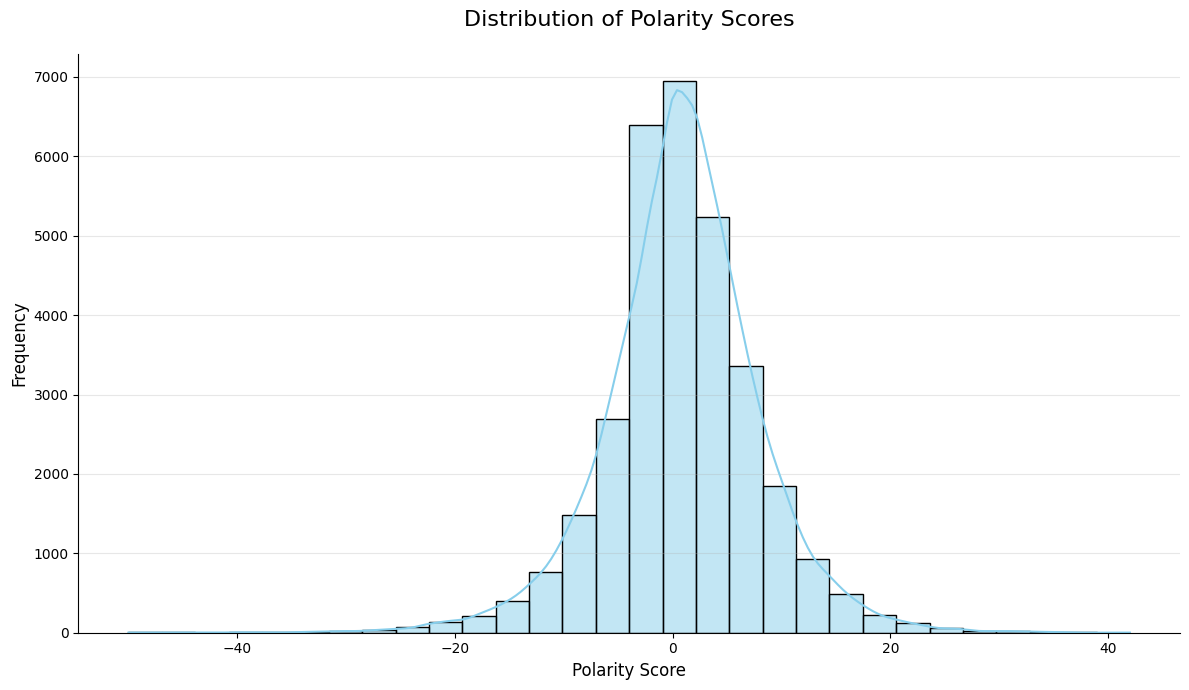

In [ ]:
# Visualization: Polarity score distribution with histogram and KDE
plt.figure(figsize=(12, 7))
sns.histplot(data=clean_df, x='polarity_score', bins=30, kde=True, color='skyblue')
plt.title('Distribution of Polarity Scores', fontsize=16, pad=20)
plt.xlabel('Polarity Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
sns.despine()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

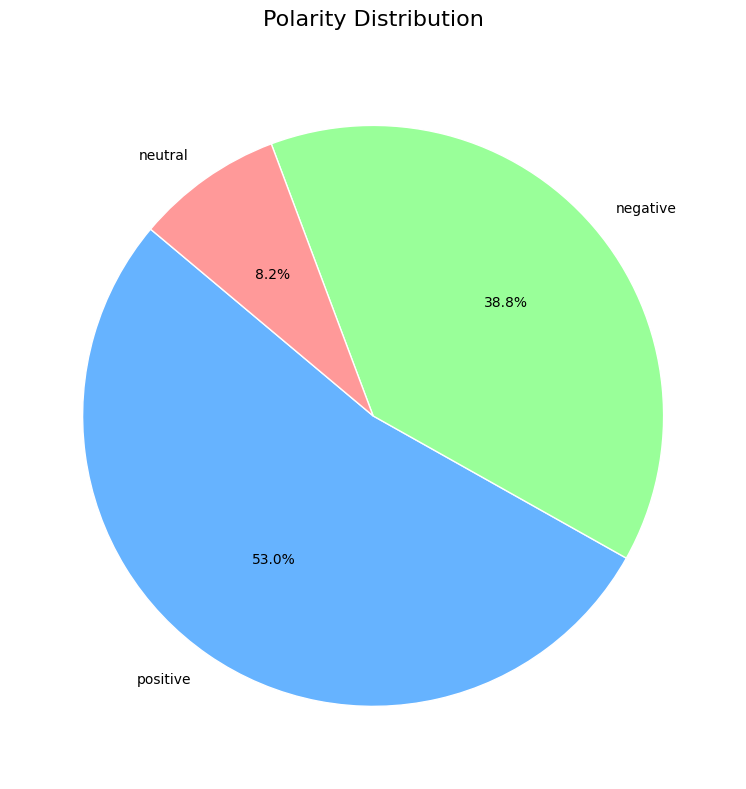

In [ ]:
# Polarity distribution visualization with pie chart
polarity_counts = clean_df['polarity'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(polarity_counts,
        labels=polarity_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=['#66b3ff','#99ff99','#ff9999'],  # Blue, green, red for neutral, positive, negative
        wedgeprops={'edgecolor': 'white', 'linewidth': 1})  # Clean edges
plt.title('Polarity Distribution', pad=20, fontsize=16)
plt.tight_layout()
plt.show()

### Wordcloud

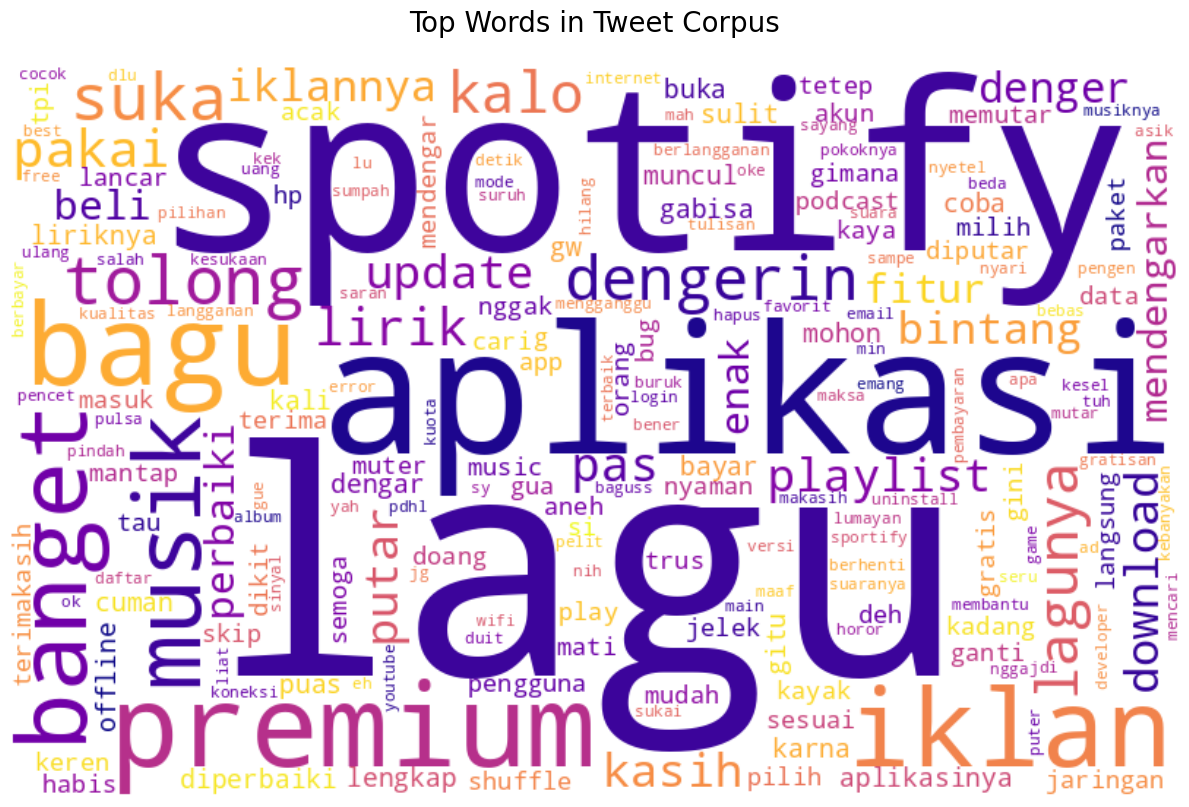

In [ ]:
# Create and display word cloud from cleaned tweets
text_corpus = ' '.join(word for tweet in clean_df['text_stopword'] for word in tweet)

wordcloud = WordCloud(
    width=800,
    height=500,
    background_color='white',
    colormap='plasma',  # Modern color palette
    max_words=200,
    min_font_size=8,
    collocations=False,  # Better for frequency representation
    stopwords=None,      # Assuming already preprocessed
    random_state=42      # For reproducibility
).generate(text_corpus)

# Configure plot
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top Words in Tweet Corpus', fontsize=20, pad=25)
plt.axis('off')
plt.tight_layout()
plt.show()

### Top Frequent Word

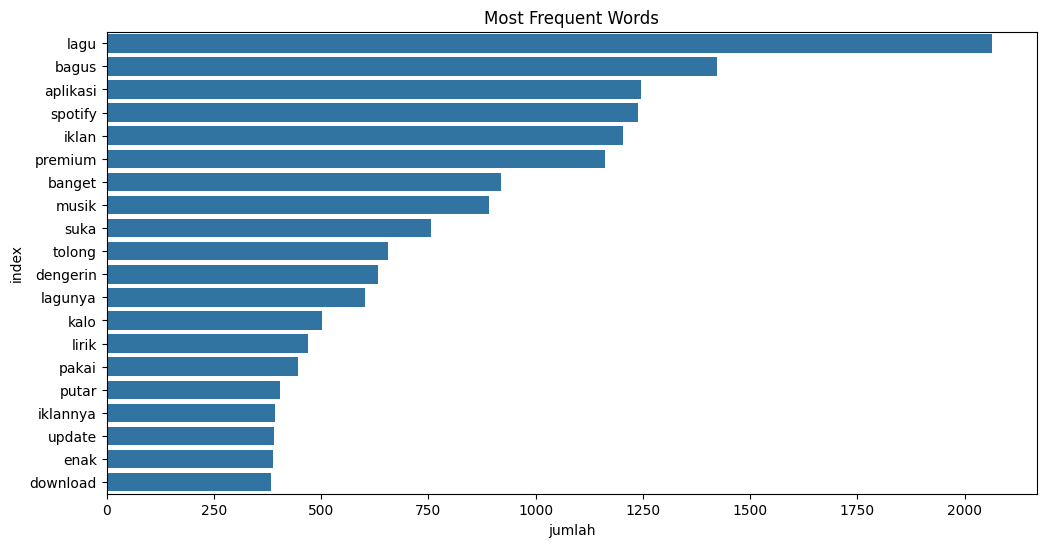

In [ ]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Set the figure size
plt.figure(figsize=(12, 6))

# Visualize most frequent words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

## Feature Extraction

In [ ]:
# Extract text and polarity columns for analysis
X = clean_df['text_akhir']
y = clean_df['polarity']

### Feature Extraction Deep Learning

In [ ]:
# Tokenisasi
max_features = 2500
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(clean_df['text_akhir'])
X = tokenizer.texts_to_sequences(clean_df['text_akhir'])
X = pad_sequences(X)

# Label encoding
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(y)
y = to_categorical(integer_encoded)

# Menentukan jumlah kelas
num_classes = y.shape[1]

# Simpan tokenizer untuk prediksi nanti
with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenisasi selesai. Tokenizer telah disimpan dalam 'tokenizer.pkl'")

Tokenisasi selesai. Tokenizer telah disimpan dalam 'tokenizer.pkl'


In [ ]:
# Custom callback to stop training when val_accuracy exceeds 0.92
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.93):
      print("\nReached 93% validation accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

## Modeling

Model dibuat dengan tiga skema berdasarkan algoritma serta komposisi data latih, validasi, dan uji sebagai berikut:

| **LSTM**          | **CNN**          | **GRU**         |
|------------------|----------------|----------------|
| Training: 80%   | Training: 80%   | Training: 90%  |
| Validation: 20% | Validation: 10% | Validation: 5% |
| Testing: 10%    | Testing: 10%    | Testing: 5%    |

### Random Forest

### LSTM (Long Short Term Memory)

In [ ]:
# Split into train+val (90%) and test (10%)
X_train_val, X_test_LSTM, y_train_val, y_test_LSTM = train_test_split(X, y, test_size=0.1, random_state=42)

# Split train+val into train (80%) and val (20%)
X_train_LSTM, X_val_LSTM, y_train_LSTM, y_val_LSTM = train_test_split(X_train_val, y_train_val, test_size=2/9, random_state=42)

In [ ]:
# Build LSTM model
model_LSTM = Sequential([
    Embedding(max_features, 256, input_length=X.shape[1]),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model with custom early stopping
batch_size = 2056
history_LSTM = model_LSTM.fit(
    X_train_LSTM, y_train_LSTM,
    epochs=50, batch_size=batch_size,
    verbose=2, callbacks=[callbacks],
    validation_data=(X_val_LSTM, y_val_LSTM)
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 - 14s - 1s/step - accuracy: 0.4549 - loss: 5.4765 - val_accuracy: 0.4935 - val_loss: 4.6349
Epoch 2/50
11/11 - 5s - 464ms/step - accuracy: 0.5426 - loss: 4.0589 - val_accuracy: 0.5976 - val_loss: 3.3719
Epoch 3/50
11/11 - 10s - 926ms/step - accuracy: 0.6452 - loss: 2.9303 - val_accuracy: 0.6778 - val_loss: 2.4324
Epoch 4/50
11/11 - 6s - 511ms/step - accuracy: 0.7171 - loss: 2.1053 - val_accuracy: 0.7468 - val_loss: 1.7762
Epoch 5/50
11/11 - 6s - 505ms/step - accuracy: 0.7499 - loss: 1.5684 - val_accuracy: 0.7586 - val_loss: 1.3718
Epoch 6/50
11/11 - 10s - 937ms/step - accuracy: 0.7865 - loss: 1.1773 - val_accuracy: 0.8044 - val_loss: 1.0322
Epoch 7/50
11/11 - 5s - 464ms/step - accuracy: 0.8244 - loss: 0.8940 - val_accuracy: 0.8321 - val_loss: 0.8182
Epoch 8/50
11/11 - 10s - 934ms/step - accuracy: 0.8480 - loss: 0.7148 - val_accuracy: 0.8241 - val_loss: 0.7037
Epoch 9/50
11/11 - 11s - 974ms/step - accuracy: 0.8704 - loss: 0.5834 - val_accuracy: 0.8656 - val_loss: 0.5700
Epoch 10/5

### CNN (Convolutional Neural Network)

In [ ]:
X_train_val, X_test_CNN, y_train_val, y_test_CNN = train_test_split(X, y, test_size=0.1, random_state=42)
X_train_CNN, X_val_CNN, y_train_CNN, y_val_CNN = train_test_split(X_train_val, y_train_val, test_size=1/9, random_state=42)

In [ ]:
model_CNN = Sequential([
    Embedding(max_features, 512, input_length=X.shape[1]),
    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_CNN.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Melatih model dengan early stopping kustom
batch_size = 2056
history_CNN = model_CNN.fit(
    X_train_CNN, y_train_CNN,
    epochs=50, batch_size=batch_size,
    verbose=2, callbacks=[callbacks],
    validation_data=(X_val_CNN, y_val_CNN)
)


Epoch 1/50
13/13 - 6s - 435ms/step - accuracy: 0.4550 - loss: 1.0452 - val_accuracy: 0.5273 - val_loss: 0.9799
Epoch 2/50
13/13 - 2s - 178ms/step - accuracy: 0.6300 - loss: 0.8747 - val_accuracy: 0.6889 - val_loss: 0.7155
Epoch 3/50
13/13 - 1s - 93ms/step - accuracy: 0.7139 - loss: 0.7073 - val_accuracy: 0.6552 - val_loss: 0.7897
Epoch 4/50
13/13 - 1s - 94ms/step - accuracy: 0.7447 - loss: 0.6013 - val_accuracy: 0.7622 - val_loss: 0.5270
Epoch 5/50
13/13 - 1s - 60ms/step - accuracy: 0.8154 - loss: 0.4552 - val_accuracy: 0.8406 - val_loss: 0.4267
Epoch 6/50
13/13 - 1s - 60ms/step - accuracy: 0.8598 - loss: 0.3694 - val_accuracy: 0.8394 - val_loss: 0.3969
Epoch 7/50
13/13 - 1s - 99ms/step - accuracy: 0.8870 - loss: 0.3150 - val_accuracy: 0.8524 - val_loss: 0.3842
Epoch 8/50
13/13 - 1s - 93ms/step - accuracy: 0.9054 - loss: 0.2757 - val_accuracy: 0.8778 - val_loss: 0.3481
Epoch 9/50
13/13 - 1s - 61ms/step - accuracy: 0.9182 - loss: 0.2457 - val_accuracy: 0.8727 - val_loss: 0.3575
Epoch 10

### GRU (Gated Recurrent Unit)

In [ ]:
X_train_val, X_test_GRU, y_train_val, y_test_GRU = train_test_split(X, y, test_size=0.05, random_state=42)
X_train_GRU, X_val_GRU, y_train_GRU, y_val_GRU = train_test_split(X_train_val, y_train_val, test_size=0.0526, random_state=42)

In [ ]:
# Initialize model
model_GRU = Sequential([
    Embedding(input_dim=max_features, output_dim=512, input_length=X.shape[1]),
    SpatialDropout1D(0.3),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(128, return_sequences=False)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile model
model_GRU.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Training parameters
batch_size = 1028

# Train model
history_GRU = model_GRU.fit(
    X_train_GRU, y_train_GRU,
    epochs=50, batch_size=batch_size,
    verbose=2, callbacks=[callbacks],
    validation_data=(X_val_GRU, y_val_GRU),
)


Epoch 1/50
28/28 - 9s - 308ms/step - accuracy: 0.5168 - loss: 2.9310 - val_accuracy: 0.6673 - val_loss: 2.1260
Epoch 2/50
28/28 - 4s - 152ms/step - accuracy: 0.7570 - loss: 1.6429 - val_accuracy: 0.8425 - val_loss: 1.1486
Epoch 3/50
28/28 - 4s - 125ms/step - accuracy: 0.8575 - loss: 0.9494 - val_accuracy: 0.8902 - val_loss: 0.7258
Epoch 4/50
28/28 - 5s - 185ms/step - accuracy: 0.8896 - loss: 0.6317 - val_accuracy: 0.8971 - val_loss: 0.5267
Epoch 5/50
28/28 - 5s - 182ms/step - accuracy: 0.9091 - loss: 0.4619 - val_accuracy: 0.9022 - val_loss: 0.4294
Epoch 6/50
28/28 - 5s - 187ms/step - accuracy: 0.9232 - loss: 0.3671 - val_accuracy: 0.9016 - val_loss: 0.3741
Epoch 7/50
28/28 - 5s - 182ms/step - accuracy: 0.9281 - loss: 0.3169 - val_accuracy: 0.9054 - val_loss: 0.3428
Epoch 8/50
28/28 - 5s - 182ms/step - accuracy: 0.9310 - loss: 0.2899 - val_accuracy: 0.8984 - val_loss: 0.3545
Epoch 9/50
28/28 - 5s - 181ms/step - accuracy: 0.9398 - loss: 0.2586 - val_accuracy: 0.8984 - val_loss: 0.3345
E

## Evaluasi Model

### LSTM (Long Short Term Memory)

In [ ]:
# Evaluasi model
score_LSTM, acc_LSTM = model_LSTM.evaluate(X_test_LSTM, y_test_LSTM, verbose=2)
print("Test accuracy: %.2f" % (acc_LSTM))

99/99 - 7s - 66ms/step - accuracy: 0.9073 - loss: 0.3725
Test accuracy: 0.91


### CNN (Convolutional Neural Network)

In [ ]:
# Model Evaluate
score_CNN, acc_CNN = model_CNN.evaluate(X_test_CNN, y_test_CNN, verbose=2,batch_size=1028)
print("Test accuracy: %.2f" % (acc_CNN))

4/4 - 1s - 129ms/step - accuracy: 0.8679 - loss: 0.9149
Test accuracy: 0.87


### GRU (Gated Recurrent Unit)

In [ ]:
score_GRU, acc_GRU = model_GRU.evaluate(X_test_GRU, y_test_GRU, verbose=2)
print("Test accuracy: %.2f" % (acc_GRU))

50/50 - 1s - 10ms/step - accuracy: 0.8851 - loss: 0.4611
Test accuracy: 0.89


## Simpan Model

In [ ]:
path = '/content/drive/Othercomputers/My Laptop/Kampus/MBKM/DBS/Semester 6 - MBKM DBS Foundation/Belajar Via Google Colaboratory/Pengembangan Machine Learing/proyek analisis sentimen/model trained'

In [ ]:
model_LSTM.save(f'{path}/model_LSTM.h5')
model_CNN.save(f'{path}/model_CNN.h5')
model_GRU.save(f'{path}/model_GRU.h5')

## Prediksi

In [ ]:
# New sample data - DANA app reviews
new_texts = [
    "Spotify luar biasa! Koleksi lagu lengkap, audio jernih, rekomendasi akurat! Premium worth it, tanpa iklan, bisa offline!",
    "Spotify jelek! Iklan banyak, lagu hilang, sering crash! Shuffle rusak, kualitas turun! Kecewa, mending pindah!",
    "Tampilan aplikasinya cukup nyaman dipakai, hanya saja kadang ada iklan yang muncul tiba-tiba di versi gratis"
]

# True labels for the texts
true_labels = ["positive", "negative", "neutral"]

# Tokenize new texts
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=X.shape[1])

# Make predictions
predictions_LSTM = model_LSTM.predict(new_padded_sequences)
predictions_CNN = model_CNN.predict(new_padded_sequences)
predictions_GRU = model_GRU.predict(new_padded_sequences)

# Convert predictions to labels
predicted_labels_LSTM = np.argmax(predictions_LSTM, axis=1)
predicted_labels_CNN = np.argmax(predictions_CNN, axis=1)
predicted_labels_GRU = np.argmax(predictions_GRU, axis=1)

predicted_labels_LSTM = labelencoder.inverse_transform(predicted_labels_LSTM)
predicted_labels_CNN = labelencoder.inverse_transform(predicted_labels_CNN)
predicted_labels_GRU = labelencoder.inverse_transform(predicted_labels_GRU)

# Display prediction results
print("\nHASIL PREDIKSI SENTIMEN UNTUK APLIKASI DANA:\n")
for i, (text, true_label, label_LSTM, label_CNN, label_GRU) in enumerate(zip(new_texts, true_labels, predicted_labels_LSTM, predicted_labels_CNN, predicted_labels_GRU)):
    print(f"Review {i+1}:")
    print(f"Teks: {text}")
    print(f"Label Asli: {true_label}")
    print(f"Prediksi LSTM: {label_LSTM}")
    print(f"Prediksi CNN: {label_CNN}")
    print(f"Prediksi GRU: {label_GRU}")
    print("-"*50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

HASIL PREDIKSI SENTIMEN UNTUK APLIKASI DANA:

Review 1:
Teks: Spotify luar biasa! Koleksi lagu lengkap, audio jernih, rekomendasi akurat! Premium worth it, tanpa iklan, bisa offline!
Label Asli: positive
Prediksi LSTM: positive
Prediksi CNN: positive
Prediksi GRU: positive
--------------------------------------------------
Review 2:
Teks: Spotify jelek! Iklan banyak, lagu hilang, sering crash! Shuffle rusak, kualitas turun! Kecewa, mending pindah!
Label Asli: negative
Prediksi LSTM: negative
Prediksi CNN: negative
Prediksi GRU: negative
--------------------------------------------------
Review 3:
Teks: bagus, tapi menurutku yang kurang dri spotify adalah lirik lagu yang gak smua lagu punya, itu menghambat bgt bagiku
Label Asli: neutral
Prediksi LSTM: positive
Prediksi CNN: neutral
Prediksi GRU: positive
--------------------------------------------------
